# Table of Contents

 1. [Table of Contents](#Table-of-Contents)
 1. [Introduction](#Introduction)
     1. [About](#About)
     1. [Notebook Setup](#Notebook-Setup)
 1. [Overview of Kernel Functions and Kernel Matrices](#Overview-of-Kernel-Functions-and-Kernel-Matrices)
     1. [Sampling Functions from the Prior](#Sampling-Functions-from-the-Prior)
     1. [Eigenvalues of the Kernel Matrix](#Eigenvalues-of-the-Kernel-Matrix)
 1. [Preconditionning the kernel matrix](#Preconditionning-the-kernel-matrix)
     1. [Monitor Growth Factor](#Monitor-Growth-Factor)
     1. [Run experiments](#Run-experiments)
     1. [Gamma factor](#Gamma-factor)
     1. [Trace of error matrix](#Trace-of-error-matrix)
     1. [Upper bound](#Upper-bound)
     1. [Pivoted Cholesky as Preconditioning Technique](#Pivoted-Cholesky-as-Preconditioning-Technique)
 1. [mBCG on kernel matrices](#mBCG-on-kernel-matrices)
 1. [mBCG Quadrature Error](#mBCG-Quadrature-Error)
     1. [Numerical routines](#Numerical-routines)
     1. [Without preconditioning](#Without-preconditioning)
     1. [With preconditioning](#With-preconditioning)
         1. [Groundtruth quadratic forms](#Groundtruth-quadratic-forms)
     1. [Numerical experiments](#Numerical-experiments)
 1. [Logdet computation](#Logdet-computation)
     1. [Without preconditionning](#Without-preconditionning)
     1. [With preconditionning](#With-preconditionning)
 1. [Likelihood computation](#Likelihood-computation)
 1. [Regression example](#Regression-example)

# Introduction

## About

Numerical experiments of the project "Gaussian Process Regression for Gaussian Process Inference". 

## Walkthrough 

Some cells perform heavy computations, those start with `%%time` and the running time 
appears under the cell. Those cells can be skipped up to the next cell containing the `pd.read_csv` function which loads the simulation results from a file in `notebook/data`. 

Moreover, if you just wanna run a specific section of this notebook, make sure you run all cells of the "Notebook Setup" below, any section should be self-contained after this. 

## Notebook Setup

In [1]:
# Reload custom modules when modified
%load_ext autoreload
%autoreload 2

In [2]:
# Import common libraries
import torch
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Custom notebook setup
%run setup_notebook.py

- adding project root in Python path
- setting default torch dtype to float64
- overriding matplotlib aesthetics


In [4]:
# Load project modules
from src.inference import compute_logdet
from src.utils import compute_logdet_bounds
from src.kernel import SquaredExponentialKernel, MaternKernel

In [5]:
# For figure labelization
param_map = {
    'lengthscale': 'l', 'nu': r'\nu'
}

def get_kernel_label(name, params):
    label_params = ', '.join(f'{param_map[param]}={value}' for param, value in params.items())
    label = f'{name} ${label_params}$'
    return label

---

# Overview of Kernel Functions and Kernel Matrices

## Sampling Functions from the Prior

We briefly explore how the choice of a kernel induces a prior distribution and the different shapes of the priors with different kernels.

The prior Gaussian Process is just the multivariate normal distribution with the kernel matrix as the covariance, since there is no data to condition the distribution on. With $\mathbf x_1, \ldots, \mathbf x_n$ the data points,

$$\mathbf y^\star \sim \mathcal N(\mathbf 0, K_{XX}), \quad (K_{XX})_{ij} = k(x_i, x_j)$$

In [6]:
# Kernels to compare
kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 0.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5})
]

In [7]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import pairwise_distances

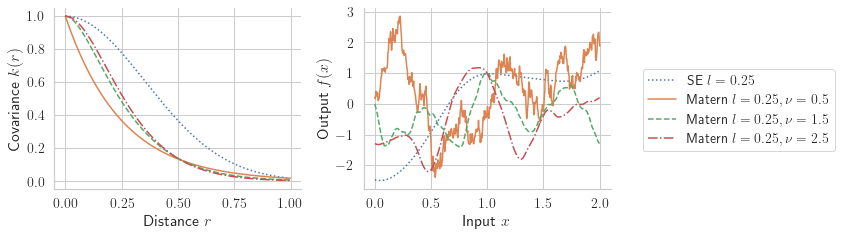

In [8]:
n = 500
x = torch.linspace(0, 2, n)

_, ax = plt.subplots(1, 2, figsize=(12, 3.5))
ls = [':', '-', '--', '-.']
for i, (kernel, desc, params) in enumerate(kernels):
    # Kernel hyperparameters
    # The noise variance does not need to be set here, use NaN
    p = torch.tensor([np.nan, *params.values()])
    # Compute kernel
    K = kernel(x).compute_kernel(p)
    # Plot kernel in function of distance
    ax[0].plot(x[:int(n/2)], K[:int(n/2), 0], label=get_kernel_label(desc, params), ls=ls[i])
    
    # Sample prior
    f = np.random.multivariate_normal(mean=np.zeros(n), cov=K)
    plt.plot(x, f, ls=ls[i], label=get_kernel_label(desc, params))
    
ax[0].set_xlabel('Distance $r$')
ax[0].set_ylabel('Covariance $k(r)$')
ax[1].set_xlabel('Input $x$')
ax[1].set_ylabel('Output $f(x)$')
plt.legend(bbox_to_anchor=(1.1, .7));
process_figure('covariance_overview')

## Eigenvalues of the Kernel Matrix

In [9]:
from src.kernel import SquaredExponentialKernel, MaternKernel

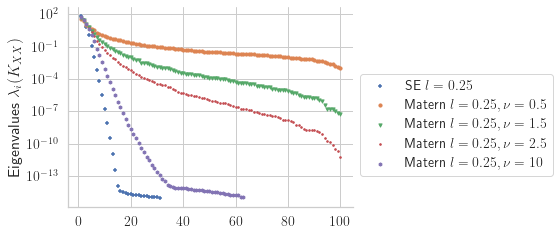

In [10]:
n = 100
x = torch.rand(n, 1)
sigma2 = 0.01

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 0.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 10}),
]

markers = ['+', 'o', 'v', '.', 'h']
plt.figure(figsize=(8, 3.5))
for i, (kernel, desc, params) in enumerate(kernels):
    K = kernel(x).compute_kernel(torch.tensor([sigma2, *params.values()]))
    
    threhsold = 1e-15
    e = torch.linalg.eigvalsh(K)
    e = np.array(e)[::-1]
    e[e < threhsold] = 0.0
    
    plt.scatter(range(1, len(e)+1), e, marker=markers[i], s=10, label=get_kernel_label(desc, params))
    
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('')
plt.ylabel('Eigenvalues $\lambda_i(K_{XX})$')
plt.legend(bbox_to_anchor=(1., .7));
process_figure('kernel_eigenvalues')
#plt.xlim([0, 100])

In [113]:
n = 1000
sigma2 = 0.1

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (MaternKernel,             'Matern', {'lengthscale': 0.1, 'nu': 1.5})
]

data = [
    ('Uniform', torch.rand),
    ('Gaussian', torch.randn)
]
reps = 5
results = []
# Loop over the data distributions
for (desc, gen_data) in data:
    # Loop over the kernels
    for i, (kernel, desc_kernel, params) in enumerate(kernels):
        # Loop over the data dimension
        for j, d in enumerate((1, 2, 3, 4)):
            # Loop over repetitions of random sampling
            for _ in range(reps):
                x = gen_data(n, d)
                K = kernel(x).compute_kernel(torch.tensor([sigma2, *params.values()]))
                eigs = torch.linalg.eigvalsh(K)
                results.append({
                    'data': desc, 'kernel': desc_kernel, 'd': d, 'eigs': eigs.numpy()
                })

In [114]:
import pandas as pd
df = pd.DataFrame(results)
df

,data,kernel,d,eigs
0,Uniform,SE,1,"[-1.1855191252605415e-13, -5.019459415324034e-..."
1,Uniform,SE,1,"[-1.1318031913624313e-13, -6.663622492878475e-..."
2,Uniform,SE,1,"[-9.766046315619121e-14, -7.671950261144393e-1..."
3,Uniform,SE,1,"[-9.843037379036756e-14, -6.059213478396086e-1..."
4,Uniform,SE,1,"[-1.066700761908957e-13, -7.376560096407096e-1..."
...,...,...,...,...
75,Gaussian,Matern,4,"[0.5574997030011636, 0.5904601318872229, 0.635..."
76,Gaussian,Matern,4,"[0.5714106407606604, 0.666344325217797, 0.6783..."
77,Gaussian,Matern,4,"[0.3095141433439555, 0.4617349957002543, 0.521..."
78,Gaussian,Matern,4,"[0.17205286709209838, 0.6027791190866634, 0.63..."


In [132]:
def get_slope(x, y, logx=False):
    mask = y > 1e-11
    x, y = x[mask], y[mask]
    if logx:
        x = np.log(x)
    y = np.log(y)
    
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [187]:
def plot_slope(x, y, ax, slope_dim1, dim, logx=False):
    if dim==1:
        return
    #mask = y > 1e-11
    #x, y = x[mask], y[mask]
    
    if logx:
        curve = slope_dim1 / dim * np.log(x)
    else:
        curve = np.exp(slope_dim1 * (x ** (1/dim)))
    
    curve *= y.max() / curve.max()
    # Might need to rescale again, there are plently of upper bounding curves depending on the slope and constant
    # We just found one of them
    ratio = y / curve
    imax = np.argmax(ratio)
    curve *= ratio.max()
    
    ax.semilogy(x, curve, '--k')

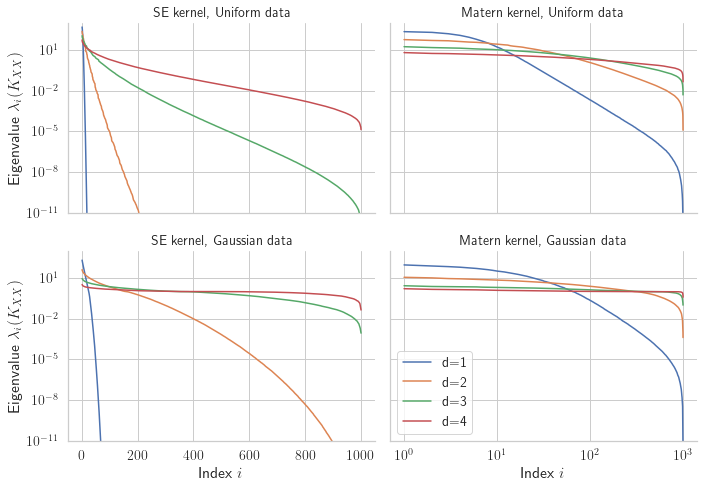

In [189]:
_, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex='col')

kernels = ['SE', 'Matern']
dists = ['Uniform', 'Gaussian']

artists = []
for i, k in enumerate(kernels):
    for j, dist in enumerate(dists):
        slope_dim1 = None
        for d in range(1,5):
            sub = df[(df.data==dist) & (df.kernel==k) & (df.d==d)]
            eigs = np.stack(sub.eigs)[:, ::-1]
            indices = np.arange(1, eigs.shape[1]+1)
            a = ax[j, i]
            mu, sd = eigs.mean(axis=0), eigs.std(axis=0)
            
            if d == 1:
                slope_dim1 = get_slope(indices, mu)
            #plot_slope(indices, mu, a, slope_dim1, d)
            
            a.semilogy(indices, mu, label=f'd={d}')
            #a.fill_between(indices, mu, mu-sd, mu+sd)
            a.set_title(f'{k} kernel, {dist} data')
            a.set_ylim((1e-11, 1e3))
            if k == 'Matern':
                a.set_xscale('log')
            

for a in ax[-1, :]: a.set_xlabel('Index $i$')
for a in ax[:, 0]: a.set_ylabel('Eigenvalue $\lambda_i(K_{XX})$')
plt.legend()
plt.tight_layout()
process_figure('kernel_eigvals')

Here's the slope for the 1D Matern kernel with uniform data:

In [239]:
from scipy.special import gamma as gamma_fun
from scipy.special import loggamma

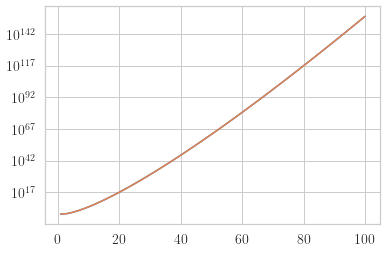

In [241]:
i = np.linspace(1, 100)
y = gamma_fun(i)
z = loggamma(i)
plt.semilogy(i, y)
plt.semilogy(i, np.exp(z))

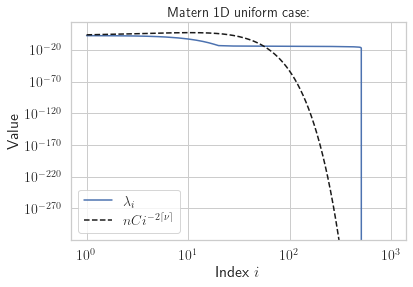

In [247]:
sub = df[(df.data == 'Uniform') & (df.kernel == 'SE') & (df.d == 1)]
mu = sub.eigs.mean()[::-1]
i = np.arange(1., len(mu)+1)

l = 1 / 0.1
# Compute the log of the upper bound since numerator and denominator are huge (overflows)
factor = i * np.log(l) - loggamma(i)

y = mu.shape[0] * np.exp(factor)

plt.loglog(i, mu, label='$\lambda_i$')
plt.loglog(i, y, '--k', label=r'$nC i^{-2 \lceil \nu \rceil}$')
plt.xlabel(r'Index $i$'); plt.ylabel('Value')
plt.title('Matern 1D uniform case: ')
plt.legend();

constant C = 233.11611909479385


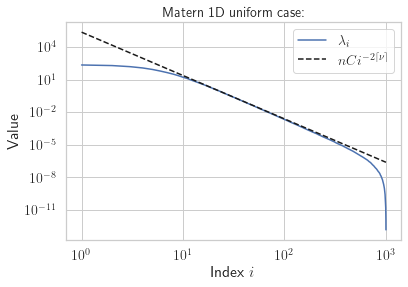

In [251]:
sub = df[(df.data == 'Uniform') & (df.kernel == 'Matern') & (df.d == 1)]
mu = sub.eigs.mean()[::-1]
i = np.arange(1., len(mu)+1)

slope = - 2 * np.ceil(1.5)
y = i ** (slope) * mu.shape[0]
C = (mu / y).max()
y *= C
print('constant C =', C)

plt.loglog(i, mu, label='$\lambda_i$')
plt.loglog(i, y, '--k', label=r'$nC i^{-2 \lceil \nu \rceil}$')
plt.xlabel(r'Index $i$'); plt.ylabel('Value')
plt.title('Matern 1D uniform case: ')
plt.legend();

---

# Preconditionning the kernel matrix

Some kernel matrices are extremely ill-conditionned, so that computing their eigenvalues with standard algorithms will fail, as shown by the example below:

In [11]:
from src.precond import PartialCholesky
from src.kernel import SquaredExponentialKernel, MaternKernel, Kernel

In [170]:
# Uniform grid on [0, 1] of n points
n = 100
x = torch.linspace(0., 1., n)

# Compute kernel matrix
lengthscale = 2.0
sigma2 = 0.1
K = SquaredExponentialKernel(x).compute_kernel(torch.tensor([sigma2, lengthscale]))

# Eigenvalues
eigs = torch.linalg.eigvalsh(K)
eigs.min()

tensor(-7.9759e-15)

Here, the computed minimum eigenvalue is $\tilde \lambda_{\min} < 0$, but we know that the true eigenvalue $\lambda_{\min} > 0$ since $K$ is SPD. Note that we won't work with $K$ directly but rather with $\widehat K := K + \sigma^2 I$, which is a very good news since $\widehat K$ is much better conditionned. However, we will rely on Lanczos algorithm to approximate some quantities, and we need the number of Lanczos steps to scale with the square root of the condition number. Therefore, we wish to accelerate the convergence of Lanczos.


We explore how the condition number of the preconditionned matrix 

$$ \widehat P^{-\frac 1 2}_k \widehat K_{XX} \widehat P^{-\frac 1 2}_k$$

behaves as a function of $k := \text{rank}(P_k)$ with $P_k = L_kL_k^\top \approx K_{XX}$. We can relate this condition number to the trace of the low-rank approximation, which itself is upper bounded by a scaling of $\Gamma_k \lambda_k(K_{XX})$

## Monitor Growth Factor

In pivoted cholesky, we have the relationship

$$\text{Trace}(K_{XX} - L_kL_k^\top) \le nC \Gamma_k \lambda_k(K_{XX}) \; .$$

We wish to monitor the upper bound $\Gamma_k \lambda_k(K_{XX})$ with different data distributions and choices of the kernel. 

In [6]:
def compute_gamma(L, k):
    """
    Compute the gamma factor
    :param L: lower triangular matrix, pivoted cholesky factor Lk after permutation
    :param k: the number of columns of k to consider
    """
    l_kk = L[k, k]
    L11 = L[:k, :k]
    norm = torch.linalg.norm(torch.linalg.inv(L11))
    gamma = l_kk**2 * norm**2
    eig_A11 = 1 / norm**2
    return gamma, eig_A11

Pathological case: triangular matrix with -1 on digonal, we get $\Gamma_k = \mathcal O(4^k)$

In [7]:
n = 1000
T = torch.randn(n, n)
T = torch.tril(T)
# Put -1 on diagonal
T -= torch.diag(T.diag(-1) + 1,-1)
# Jitter to bring diagonal away from zero
T += torch.eye(n) * 0.01

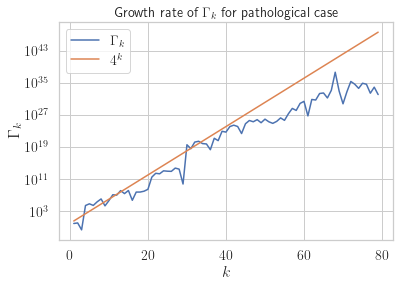

In [8]:
ks = np.arange(1,80)
pathological_gamma = [compute_gamma(T, k)[0] for k in ks]
plt.semilogy(ks, pathological_gamma, label='$\Gamma_k$')
plt.semilogy(ks, 4.**ks, label='$4^k$')

plt.xlabel('$k$'); plt.ylabel('$\Gamma_k$');
plt.title('Growth rate of $\Gamma_k$ for pathological case')
plt.legend();

## Run experiments



In [176]:
from time import perf_counter

def compute_pivchol(n, d, data_fun, data_descriptor, kernel_class, kernel_descriptor, kernel_params, sigma2, max_rank):
    x = data_fun(n, d)
    
    params = torch.concat([torch.tensor([sigma2]), torch.tensor(kernel_params)])
    start = perf_counter()
    kernel = kernel_class(x)
    kernel.compute_kernel(params)
    time_kernel = perf_counter() - start
    
    start = perf_counter()
    P = PartialCholesky(kernel.K, max_rank=max_rank, sigma2=sigma2)
    time_pivchol = perf_counter() - start
    
    eigs_kernel = torch.linalg.eigvalsh(kernel.K).numpy()[::-1]
    
    results = {
        'data': data_descriptor,
        'd': d,
        'kernel': kernel_descriptor,
        'max_rank': max_rank,
        'rank': P.k,
        'kernel_eigs': eigs_kernel,
        'kernel_params': kernel_params,
        'pivchol_trace': P.trace_errors.numpy(),
        'sigma2': sigma2,
        'time_kernel': time_kernel,
        'time_pivchol': time_pivchol
    }
    
    return results, kernel, P

In [177]:
def compute_pivchol_quantities(kernel: Kernel, P: PartialCholesky, k_stride=None):
    maxrank = P.k
    if k_stride is None:
        if maxrank <= 30:
            k_stride = 1
        elif maxrank <= 50:
            k_stride = 2
        elif maxrank <= 100:
            k_stride = 5
        else:
            k_stride = 10
    
    results = []
    ks = list(range(1, maxrank, k_stride))
    ks.append(maxrank-1)
    L = P.Lk[P.pivots]
    Khat = kernel.Khat()
    for k in ks:
        gamma, eigA11 = compute_gamma(L, k)
        
        Pk = P.truncate(k)
        precond_eigs = Pk.compute_precond_eigs()
        cond = precond_eigs.max() / precond_eigs.min()
        
        results.append({
            'k': k,
            'gamma': gamma.item(),
            'eig_A11': eigA11.item(),
            'cond': cond.item()
        })
    
    return results

In [179]:
%%time

# ======== WARNING ======== 
# Running this cell requires a lot of time, the results are saved in the following cell
# Load the results from disk if you just want to see the results


n = 1000
ds = (1, 2, 3, 4)
repetitions = 5
max_rank = 300
data = [
    ('normal', torch.randn),
    ('uniform', torch.rand)
]
sigma2, lengthscale, nu = 0.1, 0.1, 2.5
kernels = [
    ('SE', SquaredExponentialKernel, (lengthscale,)), 
    ('Matern', MaternKernel, (lengthscale, nu))
]


results = []
results_qtties = []
# Loop over configurations
for desc_kernel, kernel_class, hyperparams in kernels:
    for desc_data, data_fun in data:
        for d in ds:
            print(f'{desc_kernel} {desc_data} d={d}', end=', ')
            
            # Repeat experiments
            for r in range(repetitions):
                res, kernel, P = compute_pivchol(n, d, data_fun, desc_data, kernel_class, 
                                                 desc_kernel, hyperparams, sigma2, max_rank)
                res['r'] = r
                results.append(res)
                
                res = compute_pivchol_quantities(kernel, P)
                # Add information
                for i in range(len(res)):
                    res[i].update({
                        'kernel': desc_kernel,
                        'data': desc_data,
                        'd': d,
                        'r': r
                    })
                results_qtties.extend(res)

SE normal d=1, SE normal d=2, SE normal d=3, SE normal d=4, SE uniform d=1, SE uniform d=2, SE uniform d=3, SE uniform d=4, Matern normal d=1, Matern normal d=2, Matern normal d=3, Matern normal d=4, Matern uniform d=1, Matern uniform d=2, Matern uniform d=3, Matern uniform d=4, CPU times: user 2h 2min 8s, sys: 29.8 s, total: 2h 2min 38s
Wall time: 34min 13s


In [180]:
import pandas as pd

df = pd.DataFrame(results)
df

,data,d,kernel,max_rank,rank,kernel_eigs,kernel_params,pivchol_trace,sigma2,time_kernel,time_pivchol,r
0,normal,1,SE,300,74,"[205.79392879808046, 165.07046077255671, 136.4...","(0.1,)","[850.7384088734743, 828.1420439162749, 810.130...",0.1,0.030770,2.315671,0
1,normal,1,SE,300,73,"[209.08151905271643, 159.93213994711374, 126.6...","(0.1,)","[980.7943803257332, 818.2337704333167, 774.955...",0.1,0.016406,2.265838,1
2,normal,1,SE,300,74,"[208.95738261872907, 166.55551914853197, 128.3...","(0.1,)","[874.4092411387657, 870.0704935739772, 739.273...",0.1,0.004512,2.277218,2
3,normal,1,SE,300,76,"[192.74795270729862, 157.92396271046476, 131.9...","(0.1,)","[870.5903238734561, 830.8018271670721, 828.819...",0.1,0.004448,2.472610,3
4,normal,1,SE,300,75,"[191.23396333728755, 168.11996654528656, 127.0...","(0.1,)","[861.0981342215428, 837.6708806019864, 765.041...",0.1,0.020442,2.449532,4
...,...,...,...,...,...,...,...,...,...,...,...,...
75,uniform,4,Matern,300,300,"[5.728995701126023, 5.366613018805285, 5.13666...","(0.1, 2.5)","[997.6676242247424, 996.2494166932646, 994.823...",0.1,0.179661,8.301116,0
76,uniform,4,Matern,300,300,"[6.1244111380427135, 5.186199555004068, 5.0368...","(0.1, 2.5)","[998.8105327799929, 996.9415723696007, 995.824...",0.1,0.182429,8.277572,1
77,uniform,4,Matern,300,300,"[5.809177222371379, 5.277847934733645, 4.99245...","(0.1, 2.5)","[998.7801820343172, 997.2699629333968, 996.128...",0.1,0.178833,8.418711,2
78,uniform,4,Matern,300,300,"[5.411548910369655, 5.032662359598071, 4.72014...","(0.1, 2.5)","[998.0667078430533, 995.9823898477591, 994.273...",0.1,0.178298,8.302454,3


In [181]:
df2 = pd.DataFrame(results_qtties)
df2

,k,gamma,eig_A11,cond,kernel,data,d,r
0,1,1.000000,1.000000,1855.359038,SE,normal,1,0
1,6,5.999910,0.166667,1719.231951,SE,normal,1,0
2,11,9.925502,0.090789,972.325361,SE,normal,1,0
3,16,12.570966,0.053448,384.141551,SE,normal,1,0
4,21,6.938420,0.032183,154.941121,SE,normal,1,0
...,...,...,...,...,...,...,...,...
2321,261,256.932646,0.003773,29.463873,Matern,uniform,4,4
2322,271,266.377478,0.003627,26.374143,Matern,uniform,4,4
2323,281,276.244429,0.003492,23.382529,Matern,uniform,4,4
2324,291,285.854084,0.003366,23.378935,Matern,uniform,4,4


In [182]:
df_plot = df2.set_index(['kernel', 'data', 'd', 'r'])
df_plot = df_plot.join(df.set_index(['kernel', 'data', 'd', 'r']))
df_plot.kernel_eigs = df_plot.apply(lambda row: row.kernel_eigs[row.k], axis=1)
df_plot.pivchol_trace = df_plot.apply(lambda row: row.pivchol_trace[row.k], axis=1)
df_plot.reset_index(inplace=True)
df_plot['prod'] = df_plot.gamma * df_plot.kernel_eigs

df_plot.to_csv('data/pivoted_cholesky.csv')
df_plot

,kernel,data,d,r,k,gamma,eig_A11,cond,max_rank,rank,kernel_eigs,kernel_params,pivchol_trace,sigma2,time_kernel,time_pivchol,prod
0,Matern,normal,1,0,1,1.000000,1.000000,929.608004,300,300,77.327770,"(0.1, 2.5)",909.441528,0.1,0.204555,8.920182,77.327770
1,Matern,normal,1,0,11,10.999869,0.090909,705.763796,300,300,31.304980,"(0.1, 2.5)",687.302813,0.1,0.204555,8.920182,344.350680
2,Matern,normal,1,0,21,20.637907,0.047168,549.634015,300,300,11.654137,"(0.1, 2.5)",463.512790,0.1,0.204555,8.920182,240.516990
3,Matern,normal,1,0,31,21.842613,0.030587,299.529398,300,300,4.646249,"(0.1, 2.5)",283.772595,0.1,0.204555,8.920182,101.486229
4,Matern,normal,1,0,41,30.743004,0.017467,109.296803,300,300,2.389742,"(0.1, 2.5)",130.523988,0.1,0.204555,8.920182,73.467858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,SE,uniform,4,4,261,179.785197,0.001015,7.313044,300,300,0.260121,"(0.1,)",69.100105,0.1,0.013667,9.109783,46.765891
2322,SE,uniform,4,4,271,185.370082,0.000910,6.789129,300,300,0.234329,"(0.1,)",63.346001,0.1,0.013667,9.109783,43.437594
2323,SE,uniform,4,4,281,193.622258,0.000825,6.441629,300,300,0.210711,"(0.1,)",57.010480,0.1,0.013667,9.109783,40.798261
2324,SE,uniform,4,4,291,195.660251,0.000746,5.576443,300,300,0.190024,"(0.1,)",52.738779,0.1,0.013667,9.109783,37.180212


In [183]:
df_plot = pd.read_csv('data/pivoted_cholesky.csv')

## Gamma factor

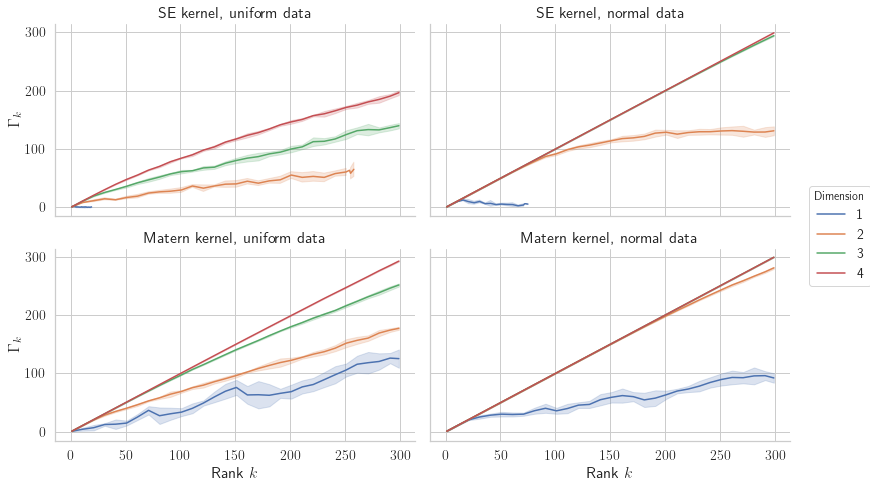

In [202]:
grid = sns.relplot(x='k', y='gamma', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', '$\Gamma_k$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')

process_figure('pivchol_gamma')

## Trace of error matrix

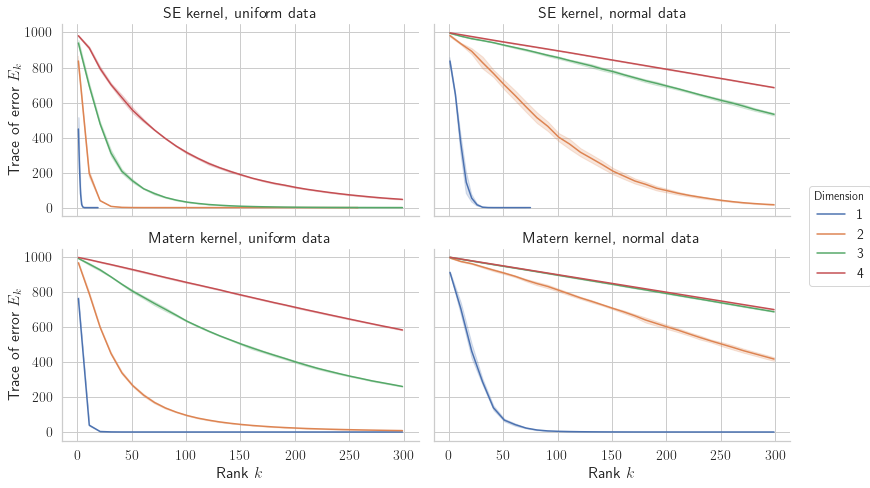

In [214]:
grid = sns.relplot(x='k', y='trace', hue='d', data=df_plot.rename(columns={'pivchol_trace': 'trace'}), palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', r'Trace of error $E_k$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_trace')

## Upper bound

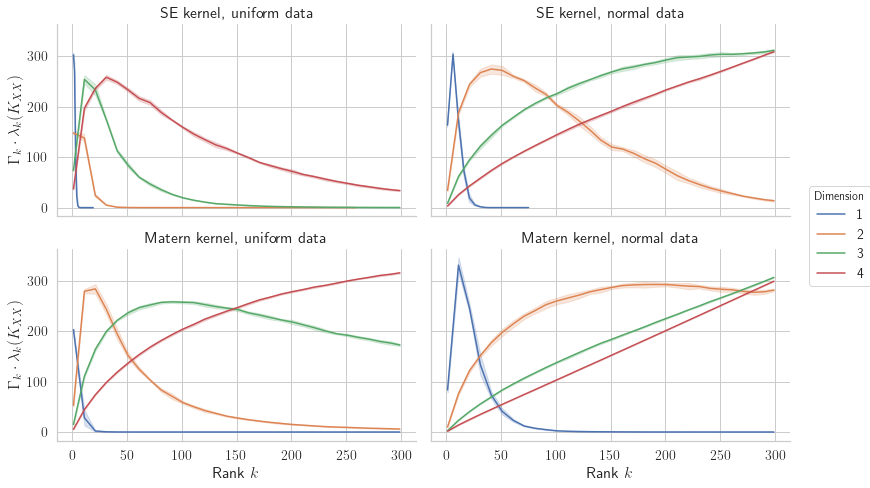

In [217]:
grid = sns.relplot(x='k', y='prod', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

grid.set_axis_labels('Rank $k$', '$\Gamma_k \cdot \lambda_k(K_{XX})$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_upperbound')

## Pivoted Cholesky as Preconditioning Technique


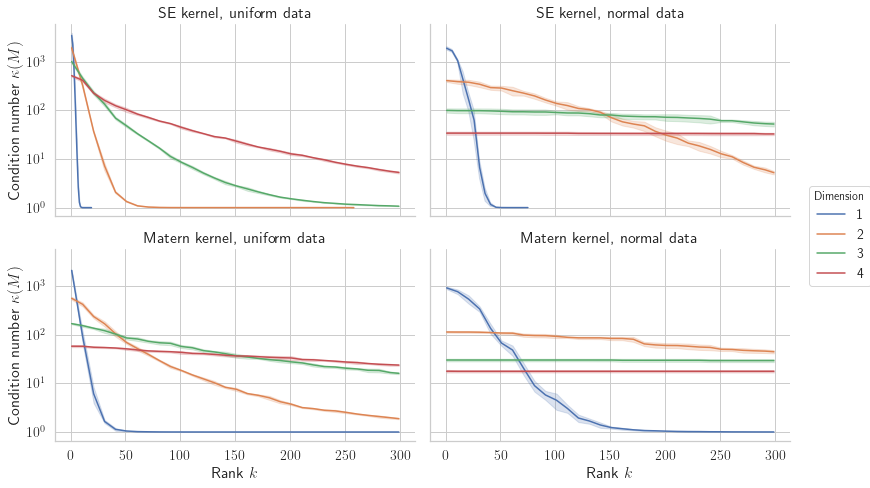

In [216]:
grid = sns.relplot(x='k', y='cond', hue='d', data=df_plot, palette='deep', 
                   ci='sd', row='kernel', col='data', kind='line', col_order=('uniform', 'normal'),
                   aspect=1.5, row_order=('SE', 'Matern'), height=3.5)

plt.yscale('log')
grid.set_axis_labels('Rank $k$', 'Condition number $\kappa(M)$')
grid.set_titles('{row_name} kernel, {col_name} data')
grid._legend.set_frame_on(True)
grid._legend.set_bbox_to_anchor((1.08,0.5))
grid._legend.set_title('Dimension')
process_figure('pivchol_cond')

---

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


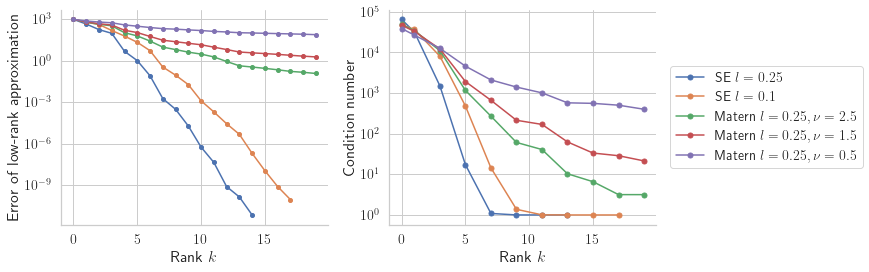

In [81]:
_, ax = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

for i, (kernel, name, params) in enumerate(kernels):
    label = get_kernel_label(name, params)
    ks_cond_nums = list([0] + list(ks_explore))[:len(cond_nums[i])]
    ks_trerr = range(len(trace_errors[i]))
    ax[1].semilogy(ks_cond_nums, cond_nums[i], '-o', label=label, markersize=5)
    ax[0].semilogy(ks_trerr, trace_errors[i], '-o', label=label, markersize=4)
    
# Aesthetics
for a in ax: a.set_xlabel('Rank $k$')
ax[1].set_ylabel('Condition number')
ax[0].set_ylabel('Error of low-rank approximation')
plt.legend(bbox_to_anchor=(1.8, .5), loc='center right')
# Save figure
process_figure('kernel_preconditionning_1d_stdnormal')

# mBCG on kernel matrices

A very quick experiment to show how the error of mBCG (for the linear solves) behaves for kernel matrices. We use a single right-hand side here, i.e. simply solve

$$\widehat K_{XX} \mathbf u = \mathbf y$$

In [9]:
from src.cg import mbcg
from src.precond import PartialCholesky

In [10]:
def callback(error_lst, xtrue):
    """
    Helper callback function: iterative methods (e.g, CG) can be provided a callback function,
    i.e. a function that will be called at each step of the iterative method with the input
    being the current solution. 
    This helper function provides a concise way of measuring the relative error at each step.
    
    :param error_lst: the list in which relative errors will be stored at each step
    :param xtrue: the true solution used to compute the error
    """
    xtrue_norm = (xtrue ** 2).sum() ** 0.5
    def inner(xk):
        """Wrapped function. `inner` will be called by the iterative methhod."""
        error_stepk = xk - xtrue
        # Compute relative error
        error_stepk = (error_stepk ** 2).sum() ** 0.5 / xtrue_norm
        error_lst.append(error_stepk)
        
    return inner

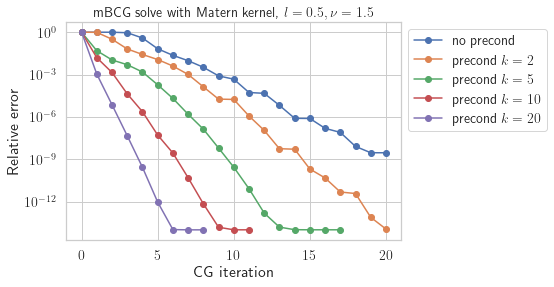

In [11]:
# Build the kernel matrix
n = 1000
sigma2 = 1
lengthscale = 0.5
nu = 1.5

grid = torch.linspace(0, 1, n)
K = MaternKernel(grid).compute_kernel(torch.tensor([sigma2, lengthscale, nu]))
Khat = K + torch.eye(n) * sigma2

# Build the system Ax = b
xtrue = torch.randn(n)
b = Khat @ xtrue

# Solve without preconditionning
k = 20
rel_errs = []
mbcg(lambda X: Khat @ X, lambda X: X, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
plt.semilogy(rel_errs, '-o', label='no precond')

# Solve with preconditionning
ranks = (2, 5, 10, 20)
for rank in ranks:
    # Compute preconditionner
    P = PartialCholesky(K, max_rank=rank, sigma2=sigma2)
    # Run mBCG
    rel_errs = []
    mbcg(lambda X: Khat @ X, P.inv_fun, b, torch.zeros(n), k=k, callback=callback(rel_errs, xtrue))
    # Plot
    plt.semilogy(rel_errs, '-o', label=f'precond $k={rank}$')

plt.xlabel('CG iteration'); plt.ylabel('Relative error')
plt.title(f'mBCG solve with Matern kernel, $l={lengthscale}, \\nu = {nu}$')
#plt.title('mBCG solve of $\widehat K_' + '_{XX}' + f' x=b$ with Matern kernel, $l={lengthscale}$')
plt.legend(bbox_to_anchor=(1,1));

---

# mBCG Quadrature Error

In this section we explore the error of Lanczos quadrature when computed with mBCG with preconditioning. 
This experiment may be seen as a sanity check, because mBCG will compute the logdet of the *preconditioned matrix*, so we won't be comparing the same quantities if we vary the rank of the preconditioner.


Specifically, we analyze the error of this approximation

$$
\mathbf z^\top (\log M) \mathbf z \approx \Vert \mathbf z \Vert_2^2 \, \mathbf e_1^\top (\log T_m) \mathbf e_1
$$

where $T_m$ is the $m$-step partial Lanczos tridiagonalization of $M$ computed with mBCG. Recall that if we precondition mBCG, we virtually run Lanczos on the preconditioned matrix. Hence, the matrix $M$ used to compute the ground truth quadratic form is

$$
M := \widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}
$$


In [6]:
import pandas as pd
import scipy as sp
from src.precond import PartialCholesky
from src.quadrature import lanczos_quadrature
from src.cg import mbcg

## Numerical routines

In [7]:
SYMMETRIC_THRESHOLD = 1e-12

def symmetrize_result(fun):
    """Decorator to symmetrize output of a matrix function"""
    def inner(*args, **kwargs):
        res = fun(*args, **kwargs)
        error = (res - res.T).abs().max()
        if error > SYMMETRIC_THRESHOLD:
            print(f'WARNING: symmetry error abs(A - A^T) greater than {SYMMETRIC_THRESHOLD} for the function {fun.__name__}')
        
        return (res + res.T) / 2

    return inner

@symmetrize_result
def logm_spd(A: torch.Tensor) -> torch.Tensor:
    """Matrix logarithm for A SPD."""
    return torch.from_numpy(sp.linalg.logm(A))

@symmetrize_result
def sqrt_spd(A: torch.Tensor) -> torch.Tensor:
    """Matrix square root for A SPD."""
    return torch.from_numpy(sp.linalg.sqrtm(A))

## Without preconditioning

We first check the consistency of Lanczos quadrature without preconditioning. We use random vectors, but note that the error is not due to randomness here.

In [10]:
# Generate data, compute kernel
n, d = 1000, 1
x = torch.randn(n, d)
k = SquaredExponentialKernel(x)

sigma2, lengthscale = 0.1, 0.1
k.compute_kernel(torch.tensor([sigma2, lengthscale]))

# Compute logarithm of Khat
logKhat = logm_spd(k.Khat())

In [11]:
# Sanity check, for SPD matrices, logdet is trace log
(logKhat.trace() - torch.logdet(k.Khat())).abs()

tensor(2.2737e-12)

In [12]:
# This cell is just to show how we perform the numerical experiment,
# this is wrapped into a function in the next cell code

# Probe vectors
N = 100
Z = torch.randn(n, N)

# Compute exact quadratic forms with explicit matrix logarithm
true_quad = ((Z.T @ logKhat) * Z.T).sum(dim=1)

# Run mBCG
m = 10
_, Ts = mbcg(k.Khat_fun, lambda x: x, Z, torch.zeros_like(Z), k=m)

# Lanczos quadrature, loop over all probe vectors
quad = torch.tensor([
    lanczos_quadrature(torch.log, Ts[i], Z[:, i], n)
    for i in range(N)
])

relerrs = ((true_quad - quad) / true_quad).abs()
relerrs.mean(), relerrs.std()

(tensor(0.0124), tensor(0.0048))

In [13]:
def compute_quadrature(A: torch.Tensor, logA: torch.Tensor, niter_list, probe_vectors, config_dict):
    """Run mBCG on a set of probe vectors and compute the quadrature error considering different number of iterations.
    To save computation time, we run mBCG only once with the maximum number of iter: this gives a big tridiag matrix T.
    For fewer iterations, the tridiag matrix used in Lanczos quadrature is just a submatrix of T."""
    max_iter = max(niter_list)
    
    # mBCG with maximum number of iterations
    residuals = []
    callback = lambda res: residuals.append(res)
    _, Ts = mbcg(lambda X: A@X, lambda X: X, probe_vectors, torch.zeros_like(probe_vectors), 
                 max_iter, callback_residuals=callback, tol=1e-50)
    # Residuals is a tensor of size max_iter x N_probe_vec
    residuals = torch.stack(residuals)
    
    # Ground truth for quadrature
    true_quads = ( (probe_vectors.T @ logA) * probe_vectors.T ).sum(dim=1)
    
    results = []
    n_probe_vectors = probe_vectors.shape[1]
    # Compute error for each probe vector
    for i in range(n_probe_vectors):
        probe_vector = probe_vectors[:, i]
        T = Ts[i]
        true_quad = true_quads[i]
        res = residuals[:, i]
        
        # Try with different number of iterations
        for niter in niter_list:
            # We may have converged earlier than niter, then stop
            if niter >= T.shape[0]:
                break
            
            # Pretend we only ran niter <= max_iter steps
            Tsub = T[:niter, :niter]
            # Lanczos quadrature
            quad = lanczos_quadrature(f=torch.log, Tm=Tsub, z=probe_vector, matrix_size=A.shape[0])
            quad_error = ((true_quad - quad) / true_quad).abs().item()
            
            results.append({
                **config_dict,
                'niter': niter,
                'quad_error': quad_error,
                'quad_true': true_quad.item(),
                'quad_estim': quad,
                'mbcg_residuals': res[niter].item(),
                'i': i # track repetition id
            })
    
    return results

Perform now the experiment without preconditioning:

In [14]:
n, d = 1000, 1
N_probe_vectors = 10
sigma2, lengthscale = 0.1, 0.1
niter_list = [1] + list(range(5, 105 + 1, 5))

x = torch.randn(n, d)

kernel = SquaredExponentialKernel(x)
kernel.compute_kernel(torch.tensor([sigma2, lengthscale]))

logKhat = logm_spd(kernel.Khat())

Z = torch.randn(n, N_probe_vectors)

res = compute_quadrature(kernel.Khat(), logKhat, niter_list, Z, {})

In [15]:
df = pd.DataFrame(res)
df

,niter,quad_error,quad_true,quad_estim,mbcg_residuals,i
0,1,8.281917e-01,-2336.708293,-401.465956,3.280417e+02,0
1,5,4.879500e-02,-2336.708293,-2222.688617,1.371491e+02,0
2,10,8.565153e-03,-2336.708293,-2316.694028,3.697486e+01,0
3,15,6.100970e-04,-2336.708293,-2335.282675,8.282035e+00,0
4,20,6.798033e-05,-2336.708293,-2336.549443,2.328202e+00,0
...,...,...,...,...,...,...
205,80,1.219217e-15,-2237.899065,-2237.899065,4.209549e-08,9
206,85,1.219217e-15,-2237.899065,-2237.899065,2.740217e-09,9
207,90,6.096084e-16,-2237.899065,-2237.899065,1.585804e-11,9
208,95,6.096084e-16,-2237.899065,-2237.899065,1.829095e-11,9


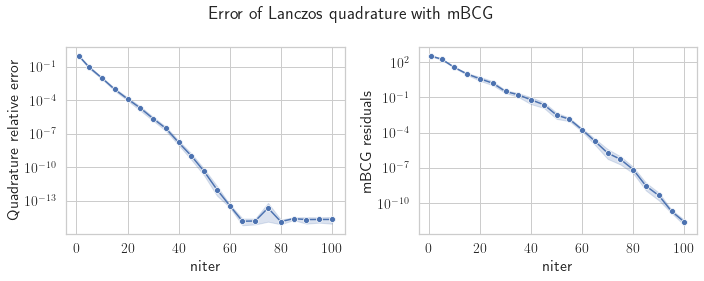

In [16]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x='niter', y='quad_error', data=df, marker='o', ax=ax[0])
ax[0].set_ylabel('Quadrature relative error')
ax[0].set_yscale('log')

sns.lineplot(x='niter', y='mbcg_residuals', data=df, marker='o', ax=ax[1])
ax[1].set_ylabel('mBCG residuals')
ax[1].set_yscale('log')
plt.suptitle('Error of Lanczos quadrature with mBCG')
plt.tight_layout()

## With preconditioning


### Groundtruth quadratic forms

We first explicitly compute the SPD preconditioned matrix $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$ to monitor the error. We have to rely on explicit computation of the square root $\widehat P_k^{1/2}$. We apply symmetrization when some oeprations destroy the symmetry to reduce propagation of errors. 

In [17]:
def compute_precond_mx(k, P, symmetric_threshold=1e-13):
    # Square root of preconditioner
    Phat_sqrt = sqrt_spd(P.Pk_hat())
    # sqrtm returns complex -> convert to real
    Phat_sqrt = Phat_sqrt.real
    
    # Apply inverse of P sqrt on the right
    Khat_times_Pinvsqrt = torch.linalg.solve(Phat_sqrt, k.Khat()).T
    # Apply inverse of P sqrt on the left
    M = torch.linalg.solve(Phat_sqrt, Khat_times_Pinvsqrt)
    # M should be symmetric
    error = (M - M.T).abs().max()
    if error > SYMMETRIC_THRESHOLD:
        print(f'Warning: threshold above {SYMMETRIC_THRESHOLD} for symmetry of preconditioned matrix')
        
    M = (M + M.T) / 2
    return M, Phat_sqrt

To check this implementation, compare the spectrum of $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$ and $\widehat P_k^{-1} \widehat K_{XX}$, they should be the same. Computation of $\widehat P_k^{-1} \widehat K_{XX}$ relies on the Woordbury formula and is thus considered more accurate.

In [18]:
# Sanity check
P = PartialCholesky(k.K, max_rank=20, sigma2=sigma2)
M, Phat_sqrt = compute_precond_mx(k, P)

precond_eigvals = torch.linalg.eigvalsh(M).flip(0)
# P.compute_precond_eigs computes eigenvalues of Pinv K
error_eigvals = (precond_eigvals - P.compute_precond_eigs()).abs() / P.compute_precond_eigs()
error_eigvals.max()

tensor(7.5262e-13)

In [21]:
M2 = P.inv_fun(k.Khat())
torch.linalg.cond(M), torch.linalg.cond(M2)

(tensor(183.8677), tensor(478.4604))

We compute the matrix logarithm of $\widehat P_k^{-1/2} \widehat K_{XX} \widehat P_k^{-1/2}$:

In [198]:
symmetric_threshold = 1e-13

logM = logm_spd(M)

# Sanity check: logdet is the trace log
(torch.logdet(M) - logM.trace()).abs()

tensor(4.9738e-13)

In [199]:
# Just to show how numerical experiments if performed for preconditioning
n, d = 1000, 1
N_probe_vectors = 100
sigma2, lengthscale = 0.1, 0.1
niter_list = list(range(1, 10)) + [50]

x = torch.rand(n, d)

kernel = SquaredExponentialKernel(x)
kernel.compute_kernel(torch.tensor([sigma2, lengthscale]))
P = PartialCholesky(kernel.K, max_rank=3, sigma2=sigma2)

# Preconditioned matrix
M, _ = compute_precond_mx(kernel, P)
logM = logm_spd(M)

Z = torch.randn(n, N_probe_vectors)
res = compute_quadrature(M, logM, niter_list, Z, {})

In [195]:
df_precond = pd.DataFrame(res)
df_precond

,niter,quad_error,quad_true,quad_estim,mbcg_residuals,i
0,1,3.089116e+01,40.406323,1288.604458,1.195552e+01,0
1,2,3.132020e+00,40.406323,166.959753,2.329343e+00,0
2,3,1.315348e+00,40.406323,93.554681,1.985040e+00,0
3,4,1.247337e-01,40.406323,45.446352,2.368708e-01,0
4,5,4.043056e-03,40.406323,40.569688,2.712902e-02,0
...,...,...,...,...,...,...
895,5,4.191304e-03,19.702606,19.785186,2.003529e-02,99
896,6,4.370505e-06,19.702606,19.702693,5.696890e-04,99
897,7,1.707706e-08,19.702606,19.702607,4.289100e-05,99
898,8,4.153877e-10,19.702606,19.702606,1.887759e-04,99


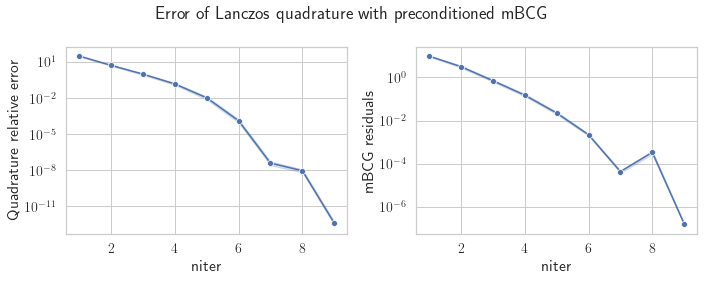

In [202]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x='niter', y='quad_error', data=df_precond, marker='o', ax=ax[0])
ax[0].set_ylabel('Quadrature relative error')
ax[0].set_yscale('log')

sns.lineplot(x='niter', y='mbcg_residuals', data=df_precond, marker='o', ax=ax[1])
ax[1].set_ylabel('mBCG residuals')
ax[1].set_yscale('log')
plt.suptitle('Error of Lanczos quadrature with preconditioned mBCG')
plt.tight_layout()

Note that in some cases, the error may saturate higher than in the unpreconditioned case. Recall that the groundtruth with preconditioning involves computing explicitly the preconditioned matrix, which may be quite inaccurate. 

## Numerical experiments

The code works. We now vary:

* The data (distribution and dimension)
* The kernel
* The rank of the preconditioner (number of pivoted Cholesky steps)

In [228]:
%%time
# Number of points
n = 1000
# Noise
sigma2 = 0.1
# mBCG settings
niter_list = list(range(1, 10 + 1)) + list(range(15, 105, 5))
N_probe_vectors = 100


data = [
    ('uniform', torch.rand),
    ('normal', torch.randn)
]
dims = (1,2,3,4)

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    #(SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.25}),
    (MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 1.5}),
#    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.1}),
#    (MaternKernel,             'Matern', {'lengthscale': 0.1, 'nu': 1.5}),
]

repeats = 2

ranks = (2, 5, 10, 20, 30)

results = []
for data_desc, data_fun in data:
    for d in dims:
        for kernel_class, kernel_desc, kernel_params in kernels:
            print(f'{data_desc} data d={d}, {kernel_desc}', end='; ')
            # Sample data & compute kernel matrix
            x = data_fun(n, d)
            kernel = kernel_class(x)
            kernel.compute_kernel(torch.tensor([sigma2, *kernel_params.values()]))
            # Sample probe vectors
            Z = torch.randn(n, N_probe_vectors)
            # Compute quantities for groundtruth
            logKhat = logm_spd(kernel.Khat())
            
            # Quadrature error without preconditioning
            config = {
                'data': data_desc,
                'd': d,
                'kernel': kernel_desc,
                'k': 0,
            }
            results.extend(compute_quadrature(kernel.Khat(), logKhat, niter_list, probe_vectors=Z, config_dict=config))
            
            # Quadrature error with preconditioning
            # Pivoted Cholesky of max rank
            Pmax = PartialCholesky(kernel.K, max_rank=max(ranks), sigma2=sigma2)
            for k in ranks:
                # If pivoted cholesky converged earlier
                if k > Pmax.k:
                    break
                
                config = {
                    'data': data_desc,
                    'd': d,
                    'kernel': kernel_desc,
                    'k': k,
                }
                
                P = Pmax.truncate(k)
                M, Phat_sqrt = compute_precond_mx(kernel, P)
                logM = logm_spd(M)
                
                res = compute_quadrature(M, logM, niter_list, probe_vectors=Z, config_dict=config)
                results.extend(res)

uniform data d=1, SE; uniform data d=1, Matern; uniform data d=2, SE; uniform data d=2, Matern; uniform data d=3, SE; uniform data d=3, Matern; uniform data d=4, SE; uniform data d=4, Matern; normal data d=1, SE; normal data d=1, Matern; normal data d=2, SE; normal data d=2, Matern; normal data d=3, SE; normal data d=3, Matern; normal data d=4, SE; normal data d=4, Matern; logm result may be inaccurate, approximate err = 2.4573461694653043e-13
logm result may be inaccurate, approximate err = 3.058248924590605e-13
CPU times: user 14min 54s, sys: 3min 42s, total: 18min 37s
Wall time: 3min 24s


In [245]:
df = pd.DataFrame(results)
df['absolute_error'] = (df.quad_true - df.quad_estim).abs()
df

,data,d,kernel,k,niter,quad_error,quad_true,quad_estim,mbcg_residuals,i,absolute_error
0,uniform,1,SE,0,1,2.304956e-01,-2315.154047,-1781.521177,2.125008e+01,0,5.336329e+02
1,uniform,1,SE,0,2,1.222230e-01,-2315.154047,-2032.188979,1.515888e+01,0,2.829651e+02
2,uniform,1,SE,0,3,8.220494e-02,-2315.154047,-2124.836949,8.154636e+00,0,1.903171e+02
3,uniform,1,SE,0,4,3.741614e-02,-2315.154047,-2228.529908,2.932765e+00,0,8.662414e+01
4,uniform,1,SE,0,5,6.244987e-03,-2315.154047,-2300.695939,5.256057e-01,0,1.445811e+01
...,...,...,...,...,...,...,...,...,...,...,...
239595,normal,4,Matern,30,75,1.845755e-15,2217.372095,2217.372095,1.308503e-19,99,4.092726e-12
239596,normal,4,Matern,30,80,1.230503e-15,2217.372095,2217.372095,3.450832e-20,99,2.728484e-12
239597,normal,4,Matern,30,85,1.230503e-15,2217.372095,2217.372095,4.648529e-22,99,2.728484e-12
239598,normal,4,Matern,30,90,2.050839e-15,2217.372095,2217.372095,1.520921e-23,99,4.547474e-12


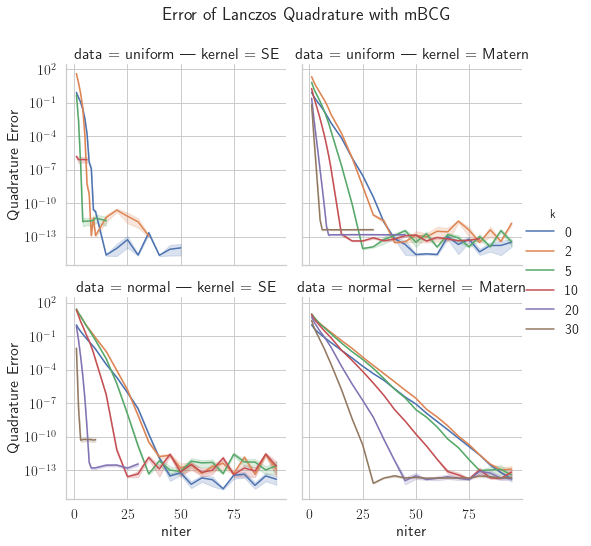

In [235]:
df_plot = df[df.d == 1].rename(columns={'quad_error': 'Quadrature Error'})
grid = sns.relplot(data=df_plot, x='niter', y='Quadrature Error', hue='k', col='kernel', row='data', 
                   kind='line', palette='deep', height=3.5)
grid.set_axis_labels()
plt.yscale('log');
plt.suptitle('Error of Lanczos Quadrature with mBCG', y=1.05);

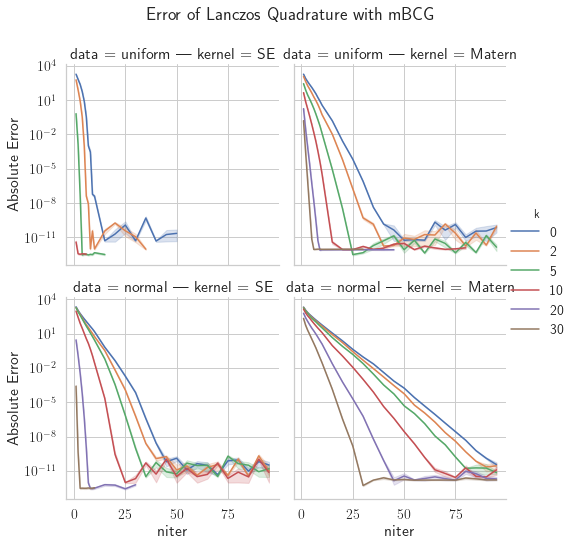

In [234]:
df_plot = df[df.d == 1].rename(columns={'absolute_error': 'Absolute Error'})
grid = sns.relplot(data=df_plot, x='niter', y='Absolute Error', hue='k', col='kernel', row='data', 
                   kind='line', palette='deep', height=3.5)
grid.set_axis_labels()
plt.yscale('log')
plt.suptitle('Error of Lanczos Quadrature with mBCG', y=1.05);

Recall that curves of different color do **not** represent the same quantities. They correspond quadratic forms with different matrices.

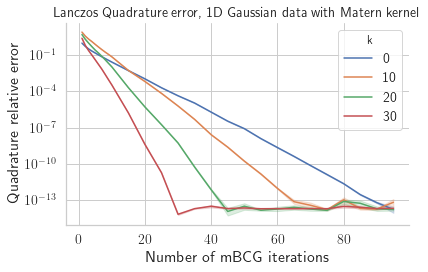

In [257]:
df_plot = df[(df.d == 1) & (df.kernel == 'Matern') & (df.data == 'normal') & ((df.k>=10)|(df.k==0))].copy()
df_plot.rename(columns={'quad_error': 'Quadrature relative error'}, inplace=True)
sns.lineplot(x='niter', y='Quadrature relative error', data=df_plot, hue='k', palette='deep')
plt.yscale('log')
plt.xlabel('Number of mBCG iterations')
plt.title('Lanczos Quadrature error, 1D Gaussian data with Matern kernel')
process_figure('quadrature_1d_gaussian_matern')

---

# Logdet computation

In [172]:
from src.inference import inference, compute_logdet
from src.model import GPModel

We study the convergence w.r.t. the number of probe vectors $N$. We are interested in the 95th quantile of the errors, so we must run several repetitions of the algorithm for each $N$ value. 

As an implementation note: since the code is in Python, it is very slow to call the inference engine many time. However, if we use many probe vectors, the computational overhead is essentially handled by low-level code. We just exploit that probe vectors are iid, so their corresponding logdet estimator are iid as well.

So if we want to call `inference` $r$ times with $N$ probe vectors, we rather call it once with $N\times r$ probe vectors, use the argument `return_avg=False`, and post-process the array. 

## Without preconditionning

We don't use kernel matrices here, as the condition number might get quite bad for big matrices, and the point is to show how stochastic lanczos quadrature works in general.

We show two experiments: a gentle and a "harder" case. This notion depends on the quantity

$$\frac{\Vert \log A \Vert_F^2}{\text{Tr}(A)^2} \; ,$$

which is always smaller than one for SPD matrices. The intuition is as follows: the frobenius norm is the variance of the trace estimator

$$\mathbf z^\top (\log A) \mathbf z \; .$$

Hence, if the trace is large compared to the frobenius norm (i.e., the above ratio is small), the variance will be small compared to the quantity of interest and only a few probe vectors are sufficient to obtain a good accuracy. On the other hand, if the frobenius norm is in the order of the trace, then many probe vectors are required to reach a good accuracy.


In [173]:
from math import floor

def postprocess_results(res, N):
    """
    Given a list of iid estimators, compute Monte Carlo estimates of N samples each.
    """
    quantiles = []
    res = np.array(res)
    np.random.shuffle(res)
    
    # Compute max number of replicas that we can make
    r = floor(res.shape[0] / N)
    # Discard extra samples
    res = res[:r*N]
    
    # Reshape as if we had r estimates and compute the mean
    res = res.reshape(r, N)
    res = res.mean(axis=1)
    return res

Let us start with the less gentle matrix:

In [175]:
n = 1000

# Build matrix
Q = torch.from_numpy(ortho_group.rvs(n))
eigs = torch.ones(n)
num = 10
eigs[0:num] = torch.linspace(10, 10*num, num)
A = Q @ torch.diag(eigs) @ Q.T

# Compute true logdet
truelogdet = eigs.log().sum().item()
truelogdet

38.13026350301597

In [177]:
relerr = 0.01
proba = 0.05
quantile = 1 - proba
info = dict()
Nbound, mbound = compute_logdet_bounds(eigs, relerr=relerr, proba_error=proba, info=info)
Nbound, mbound

(72466.66366251014, 50.84175617682864)

In [178]:
%%time
Ntot = int(5e4)
ms = (1, 2, 3, 4, 5, 10, 20, 50)
Ns = (1, 10, 100, 1000, 5000)

estimates = compute_logdet(A, Ntot, ms, return_avg=False)
res_q = dict()
for i, m in enumerate(ms):
    buffer = []
    for N in Ns:
        # Form Monte Carlo estimators with N samples each from the Ntot estimates
        res = postprocess_results(estimates[i, :], N)
        if i == 0:
            print(f'N={N} using {len(res)} Monte Carlo estimators')
        # Compute rel error and quantile
        relerrs = np.abs(res - truelogdet) / truelogdet
        q = np.quantile(relerrs, quantile)
        buffer.append(q)
        
    res_q[m] = buffer

N=1 using 50000 Monte Carlo estimators
N=10 using 5000 Monte Carlo estimators
N=100 using 500 Monte Carlo estimators
N=1000 using 50 Monte Carlo estimators
N=5000 using 10 Monte Carlo estimators
CPU times: user 1min 41s, sys: 22.4 s, total: 2min 3s
Wall time: 42.4 s


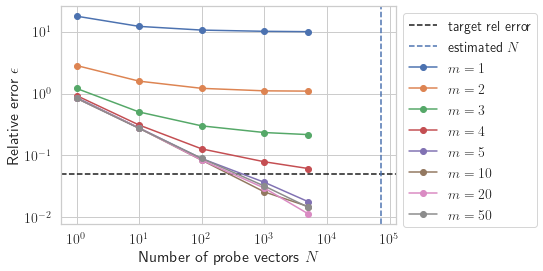

In [180]:
plt.axhline(1-quantile, ls='--', color='k', label='target rel error')
plt.axvline(Nbound, ls='--', label='estimated $N$')
for m, qs in res_q.items():
    plt.loglog(Ns, qs, '-o', label=f'$m={m}$')
    
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error $\epsilon$')
plt.legend(bbox_to_anchor=(1,1));

Now the gentle matrix:

In [181]:
n = 1000

Q = torch.from_numpy(ortho_group.rvs(n))
eigs = torch.linspace(1, n, n)
A = Q @ torch.diag(eigs) @ Q.T

truelogdet = eigs.log().sum().item()
truelogdet

5912.128178488164

In [182]:
Nbound2, mbound2 = compute_logdet_bounds(eigs, relerr=relerr, proba_error=proba, info=info)
Nbound2, mbound2

(720.5861223854071, 131.58468193485206)

In [183]:
%%time
Ntot = int(5e4)
ms = (1, 2, 3, 4, 5, 10, 20, 50)
Ns = (1, 10, 100, 1000, 5000)

estimates = compute_logdet(A, Ntot, ms, return_avg=False)
res_q2 = dict()
for i, m in enumerate(ms):
    buffer = []
    for N in Ns:
        # Form Monte Carlo estimators with N samples each from the Ntot estimates
        res = postprocess_results(estimates[i, :], N)
        if i == 0:
            print(f'N={N} using {len(res)} Monte Carlo estimators')
        # Compute rel error and quantile
        relerrs = np.abs(res - truelogdet) / truelogdet
        q = np.quantile(relerrs, quantile)
        buffer.append(q)
        
    res_q2[m] = buffer

N=1 using 50000 Monte Carlo estimators
N=10 using 5000 Monte Carlo estimators
N=100 using 500 Monte Carlo estimators
N=1000 using 50 Monte Carlo estimators
N=5000 using 10 Monte Carlo estimators
CPU times: user 4min 30s, sys: 57.1 s, total: 5min 27s
Wall time: 1min 19s


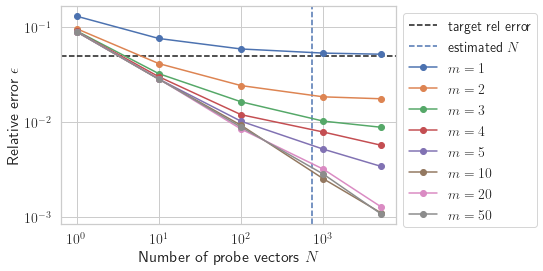

In [184]:
plt.axhline(1-quantile, ls='--', color='k', label='target rel error')
plt.axvline(Nbound2, ls='--', label='estimated $N$')
for m, qs in res_q2.items():
    plt.loglog(Ns, qs, '-o', label=f'$m={m}$')
    
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error $\epsilon$')
plt.legend(bbox_to_anchor=(1,1));

And make a nice figure for the report:

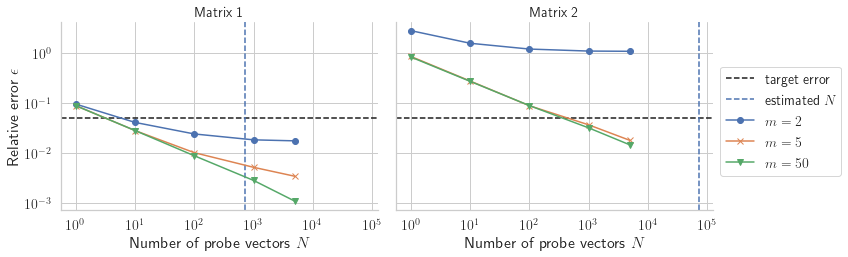

In [185]:
_, ax = plt.subplots(1, 2, figsize=(12, 3.8), sharex=True, sharey=True)
Nbounds = (Nbound2, Nbound)
plot_ms = (2, 5, 50)
markers = ('o', 'x', 'v')

for i, q in enumerate((res_q2, res_q)):
    ax[i].axhline(1-quantile, ls='--', color='k', label='target error')
    ax[i].axvline(Nbounds[i], ls='--', label='estimated $N$')
    for m, marker in zip(plot_ms, markers):
        qs = q[m]
        ax[i].loglog(Ns, qs, label=f'$m={m}$', marker=marker)

    ax[i].set_title(f'Matrix {i+1}')
    ax[i].set_xlabel('Number of probe vectors $N$')
    
ax[0].set_ylabel('Relative error $\epsilon$')
ax[1].legend(bbox_to_anchor=(1,.8));
    
plt.tight_layout();
process_figure('logdet_mbcg')

## With preconditionning

In [485]:
%%time
info = dict()

ks = (0, 10, 20, 30, 40, 50)
Ns = (1, 10, 100)
#Ns = (100,)
reps = (100, 100, 100)
mbcg_tol = 1e-13

results = []
for k in ks:
    for N, r in zip(Ns, reps):
        err_logdet = []
        err_traces = []
        for i in range(r):
            Kinvy, logdet, traces = inference(y, K, k=k, N=N, m=150, info=info, mbcg_tol=mbcg_tol)

            err_logdet.append(abs(logdet.item() - logdet_true) / abs(logdet_true))
            err_traces.append(torch.abs((traces - traces_true) / traces_true))
            err_Kinvy = torch.norm(Kinvy - Kinvy_true) / torch.norm(Kinvy_true)
            
            results.append({
                'k': info['rank'],
                'N': N,
                'i': i,
                'err_logdet': err_logdet[-1],
                'err_traces': err_traces[-1],
                'err_linsolve': err_Kinvy,
                'niter': info['niter'],
            })

        print(f'N={N}, r={r}, info={info}', end=', ')

N=1, r=100, info={'niter': 90, 'rank': 0}, N=10, r=100, info={'niter': 92, 'rank': 0}, N=100, r=100, info={'niter': 92, 'rank': 0}, N=1, r=100, info={'niter': 39, 'rank': 10}, N=10, r=100, info={'niter': 39, 'rank': 10}, N=100, r=100, info={'niter': 38, 'rank': 10}, N=1, r=100, info={'niter': 18, 'rank': 20}, N=10, r=100, info={'niter': 18, 'rank': 20}, N=100, r=100, info={'niter': 18, 'rank': 20}, N=1, r=100, info={'niter': 10, 'rank': 30}, N=10, r=100, info={'niter': 10, 'rank': 30}, N=100, r=100, info={'niter': 10, 'rank': 30}, N=1, r=100, info={'niter': 7, 'rank': 40}, N=10, r=100, info={'niter': 7, 'rank': 40}, N=100, r=100, info={'niter': 7, 'rank': 40}, N=1, r=100, info={'niter': 5, 'rank': 50}, N=10, r=100, info={'niter': 5, 'rank': 50}, N=100, r=100, info={'niter': 5, 'rank': 50}, CPU times: user 1h 9min 6s, sys: 6.13 s, total: 1h 9min 12s
Wall time: 34min 41s


In [492]:
df = pd.DataFrame(results)
df['err_trace_noise'] = df.err_traces.apply(lambda e: e[0])
df['err_trace_l'] = df.err_traces.apply(lambda e: e[1])

df.drop(columns='err_traces', inplace=True)
cols = [e for e in df.columns if 'err' in e]
df[cols] = df[cols].applymap(float)
df.rename(columns=lambda s: s.replace('_', ' '), inplace=True)

df.to_csv('data/inference_uniform2D.csv', index=False)
df

,k,N,i,err logdet,err linsolve,niter,err trace noise,err trace l
0,0,1,0,1.203823e-02,5.440237e-14,90,0.001634,0.275784
1,0,1,1,4.350965e-03,5.433917e-14,91,0.012332,0.233716
2,0,1,2,2.495069e-02,5.440237e-14,90,0.010215,0.117445
3,0,1,3,8.955588e-02,5.440237e-14,90,0.083655,0.497828
4,0,1,4,2.189623e-02,5.440237e-14,90,0.031906,0.432230
...,...,...,...,...,...,...,...,...
1795,50,100,95,6.064087e-07,7.580000e-14,5,0.000171,0.072425
1796,50,100,96,9.159861e-07,7.580000e-14,5,0.009787,0.031038
1797,50,100,97,1.453456e-06,7.580000e-14,5,0.001674,0.004231
1798,50,100,98,1.201936e-06,7.580000e-14,5,0.004118,0.032029


In [32]:
df = pd.read_csv('data/inference_uniform2D.csv')

In [34]:
def set_ylim(ax):
    ymin, ymax = ax.get_ylim()
    expmin = np.floor(np.log10(ymin))
    expmax = np.ceil(np.log10(ymax))
    ax.set_ylim((10**expmin, 10**expmax))

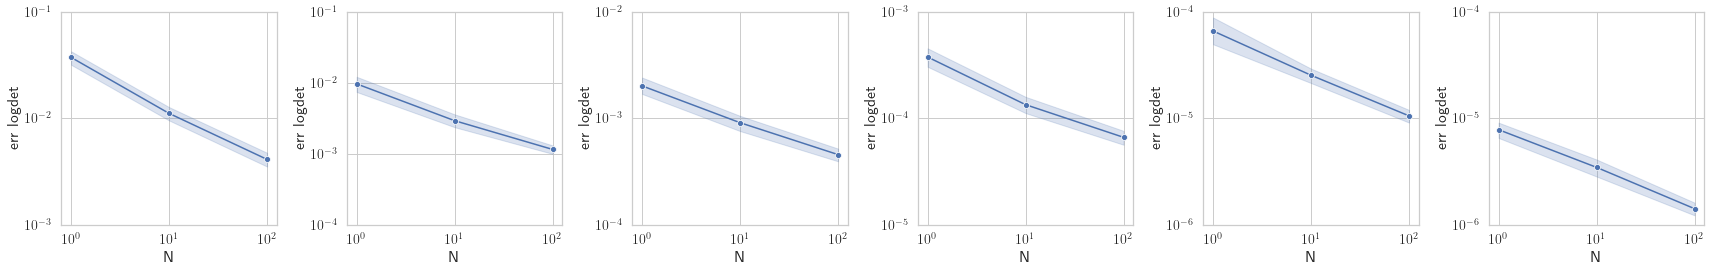

In [36]:
ks = (0, 10, 20, 30, 40, 50)
Ns = (1, 10, 100)

_, ax = plt.subplots(1, len(ks), figsize=(4 * len(ks), 4), sharex=True)

for i, k in enumerate(df.k.unique()):
    sns.lineplot(data=df[df.k==k], x='N', y='err logdet', ax=ax[i], marker='o')
    ax[i].set_yscale('log')
    set_ylim(ax[i])
    
plt.xscale('log');
plt.tight_layout()

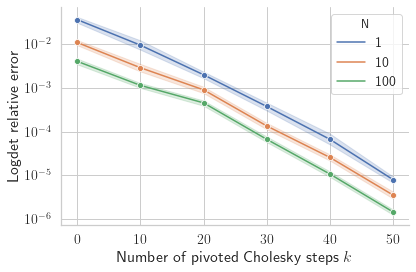

In [506]:
#sns.lineplot(data=df, x='N', y='err logdet', hue='k', palette='deep')
sns.lineplot(data=df, x='k', y='err logdet', hue='N', palette='deep', marker='o')
plt.xlabel('Number of pivoted Cholesky steps $k$')
plt.ylabel('Logdet relative error')
plt.yscale('log'); #plt.xscale('log')
process_figure('inference_logdet')

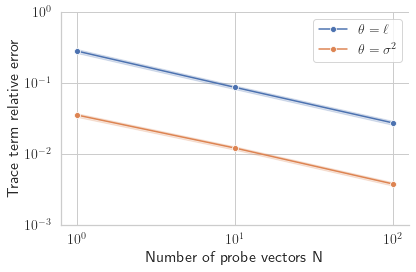

In [39]:
sns.lineplot(data=df, x='N', y='err trace l', marker='o', label=r'$\theta = \ell$')
sns.lineplot(data=df, x='N', y='err trace noise', marker='o', label=r'$\theta = \sigma^2$')
plt.xscale('log'); plt.yscale('log')
plt.ylabel('Trace term relative error')
plt.xlabel('Number of probe vectors N')
set_ylim(plt.gca())
process_figure('inference_traces')

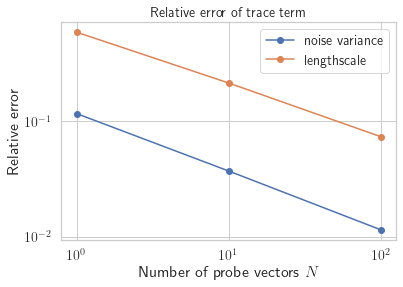

In [390]:
data = []
for N in Ns:
    data_plot = [
        errs_traces[(k, N)] for k in ks if k > 0
    ]
    data_plot = torch.stack(data_plot).mean(dim=0)
    data.append(data_plot)
    
data = torch.stack(data)
plt.loglog(Ns, data[:, 0], '-o', label='noise variance')
plt.loglog(Ns, data[:, 1], '-o', label='lengthscale')
plt.legend();
plt.xlabel('Number of probe vectors $N$')
plt.ylabel('Relative error')
plt.title('Relative error of trace term');

# Likelihood computation

In [6]:
from src.model import GPModel
from src.inference import inference

In [7]:
from time import perf_counter
import pandas as pd

In [8]:
n = 1000
#x = torch.linspace(0, 1, n)
x = torch.rand(n, 2)
#x = (x - x.mean(0)) / x.std(0)
y = (2*torch.pi*x[:, 0]).sin() - (2*torch.pi*x[:, 1]).cos()

sigma2, lengthscale = 0.1, 0.2

K = SquaredExponentialKernel(x)
K.compute_kernel_and_grad(torch.tensor([sigma2, lengthscale]))

print(f'cond num: {torch.linalg.cond(K.Khat())}')

# True quantities
logdet_true = torch.logdet(K.Khat())
M_trace = torch.linalg.solve(K.Khat(), K.grad)
traces_true = torch.tensor([torch.trace(M) for M in M_trace])

Kinvy_true = torch.linalg.solve(K.Khat(), y)

# Just run once to check errors
ysolve, logdet, traces = inference(y, K, k=5, N=5, m=100)

# Compute and display errors
err_kinvy = (Kinvy_true-ysolve).norm() / Kinvy_true.norm()
err_logdet = (logdet-logdet_true) / logdet_true
err_traces = ((traces_true - traces) / traces_true).abs()

err_kinvy, err_logdet, err_traces

cond num: 3780.847396885782


(tensor(1.6677e-11), tensor(0.0180), tensor([0.0073, 0.2487]))

To compute the groundtruth of the likelihood, one could try using sklearn [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.log_marginal_likelihood). However, one must first fit the model (i.e. run optimization) to be able calling `log_marginal_likelihood`, and it seems not possible to control the noise variance after fitting. We thus rely on exact computations implemented in `GPModel`, with the argument `compute_true_quantities=True`:

In [9]:
model = GPModel(x, y, K, torch.tensor([sigma2, lengthscale]), compute_true_quantities=True)

inference_results = None
def callback(*args):
    global inference_results
    inference_results = args

L, dL, _ = model.compute_likelihood(k=10, N=20, m=20, callback_inference=callback)

# True quantities
L_true = model._true_training_likelihoods[0]
dL_true = model._true_training_likelihoods_grad[0]

(L-L_true)/L_true, ((dL-dL_true)/(dL_true)).abs()

(tensor(-0.0372), tensor([0.0047, 0.0841]))

In [10]:
%%time

n, d = 1000, 2
x = torch.rand(n, d)
y = torch.rand(n)#(2*torch.pi*x[:, 0]).sin() - (2*torch.pi*x[:, 1]).cos()

sigma2 = 0.1

kernels = [
    # | --- class object ---| |-- name -|  |-- parameters ----|
    (SquaredExponentialKernel, 'SE',     {'lengthscale': 0.2}),
    #(MaternKernel,             'Matern', {'lengthscale': 0.25, 'nu': 2.5}),
]

data = []

reps = 100
ks = (0, 10, 20, 30, 40, 50,)
Ns = (1, 10, 100)

def callback(*args):
    global ysolve, logdet, traces
    ysolve, logdet, traces = args

for kernel, desc, params in kernels:
    hyperparams = torch.tensor([sigma2, *params.values()])
    K = kernel(x)
    
    model = GPModel(x, y, K, hyperparams, compute_true_quantities=True)
    model.compute_likelihood()
    L_true = model._true_training_likelihoods[0]
    dL_true = model._true_training_likelihoods_grad[0]
    
    logdet_true = torch.logdet(K.Khat())
    M_trace = torch.linalg.solve(K.Khat(), K.grad)
    traces_true = torch.tensor([torch.trace(M) for M in M_trace])

    Kinvy_true = torch.linalg.solve(K.Khat(), y)
    
    for N in Ns:
        print(f'{desc}, N={N}', end=' ')
        for k in ks:
            print(f'k={k}', end=' ')
            for r in range(reps):
                info = dict()
                start = perf_counter()
                
                ysolve, logdet, traces = None, None, None
                L, dL, ysolve = model.compute_likelihood(k=k, N=N, m=250, info=info, mbcg_tol=1e-10, callback_inference=callback)
                dt = perf_counter() - start
                
                err_L = ((L - L_true) / L_true).abs().item()
                err_dL = ((dL - dL_true) / dL_true).abs()
                
                err_y = ((ysolve - Kinvy_true).norm() / Kinvy_true.norm()).item()
                err_logdet = ((logdet_true - logdet) / logdet_true).abs().item()
                err_traces = ((traces - traces_true) / traces_true).abs()
                
                data.append({
                    'kernel': desc,
                    'kernel_params': params,
                    'k': k,
                    'err_L': err_L,
                    'err_dL': err_dL,
                    'err_y': err_y,
                    'err_logdet': err_logdet,
                    'err_traces': err_traces,
                    'time': dt,
                    'niter': info['niter'],
                    'N': N,
                    'r': r
                })
            print(', ', end='')

SE, N=1 k=0 , k=10 , k=20 , k=30 , k=40 , k=50 , SE, N=10 k=0 , k=10 , k=20 , k=30 , k=40 , k=50 , SE, N=100 k=0 , k=10 , k=20 , k=30 , k=40 , k=50 , CPU times: user 46min 31s, sys: 9.01 s, total: 46min 40s
Wall time: 27min 25s


In [12]:
df = pd.DataFrame(data)
df['err_dL1'] = df.err_dL.apply(lambda e: e[0].item())
df['err_dL2'] = df.err_dL.apply(lambda e: e[1].item())
df['err_trace1'] = df.err_traces.apply(lambda e: e[0].item())
df['err_trace2'] = df.err_traces.apply(lambda e: e[1].item())
df = df.drop(['err_dL', 'err_traces'], axis=1)

df.to_csv('data/likelihood.csv', index=False)

df

,kernel,kernel_params,k,err_L,err_y,err_logdet,time,niter,N,r,err_dL1,err_dL2,err_trace1,err_trace2
0,SE,{'lengthscale': 0.2},0,5.280399e-01,2.610197e-13,1.106419e-01,0.076845,83,1,0,0.698722,1.429022,0.109697,1.069925
1,SE,{'lengthscale': 0.2},0,1.787751e-01,2.643338e-13,3.745931e-02,0.078061,82,1,1,0.190652,0.336503,0.029932,0.251943
2,SE,{'lengthscale': 0.2},0,1.142463e-01,2.600989e-12,2.393838e-02,0.153304,77,1,2,0.088692,0.279906,0.013924,0.209569
3,SE,{'lengthscale': 0.2},0,1.544161e-01,2.600989e-12,3.235528e-02,0.199452,77,1,3,0.291041,1.498979,0.045693,1.122303
4,SE,{'lengthscale': 0.2},0,2.157397e-01,2.600989e-12,4.520461e-02,0.076460,77,1,4,0.244133,0.106788,0.038328,0.079953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,SE,{'lengthscale': 0.2},50,1.090832e-05,9.362505e-13,2.285655e-06,1.635806,4,100,95,0.009874,0.025642,0.001550,0.019198
1796,SE,{'lengthscale': 0.2},50,8.741280e-07,9.362505e-13,1.831588e-07,1.602233,4,100,96,0.015032,0.031970,0.002360,0.023937
1797,SE,{'lengthscale': 0.2},50,2.291386e-06,9.362505e-13,4.801212e-07,1.655705,4,100,97,0.021043,0.036530,0.003304,0.027351
1798,SE,{'lengthscale': 0.2},50,1.152711e-05,9.362505e-13,2.415312e-06,1.608759,4,100,98,0.007402,0.025823,0.001162,0.019334


In [13]:
df = pd.read_csv('data/likelihood.csv')
df

,kernel,kernel_params,k,err_L,err_y,err_logdet,time,niter,N,r,err_dL1,err_dL2,err_trace1,err_trace2
0,SE,{'lengthscale': 0.2},0,5.280399e-01,2.610197e-13,1.106419e-01,0.076845,83,1,0,0.698722,1.429022,0.109697,1.069925
1,SE,{'lengthscale': 0.2},0,1.787751e-01,2.643338e-13,3.745931e-02,0.078061,82,1,1,0.190652,0.336503,0.029932,0.251943
2,SE,{'lengthscale': 0.2},0,1.142463e-01,2.600989e-12,2.393838e-02,0.153304,77,1,2,0.088692,0.279906,0.013924,0.209569
3,SE,{'lengthscale': 0.2},0,1.544161e-01,2.600989e-12,3.235528e-02,0.199452,77,1,3,0.291041,1.498979,0.045693,1.122303
4,SE,{'lengthscale': 0.2},0,2.157397e-01,2.600989e-12,4.520461e-02,0.076460,77,1,4,0.244133,0.106788,0.038328,0.079953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,SE,{'lengthscale': 0.2},50,1.090832e-05,9.362505e-13,2.285655e-06,1.635806,4,100,95,0.009874,0.025642,0.001550,0.019198
1796,SE,{'lengthscale': 0.2},50,8.741280e-07,9.362505e-13,1.831588e-07,1.602233,4,100,96,0.015032,0.031970,0.002360,0.023937
1797,SE,{'lengthscale': 0.2},50,2.291386e-06,9.362505e-13,4.801212e-07,1.655705,4,100,97,0.021043,0.036530,0.003304,0.027351
1798,SE,{'lengthscale': 0.2},50,1.152711e-05,9.362505e-13,2.415312e-06,1.608759,4,100,98,0.007402,0.025823,0.001162,0.019334


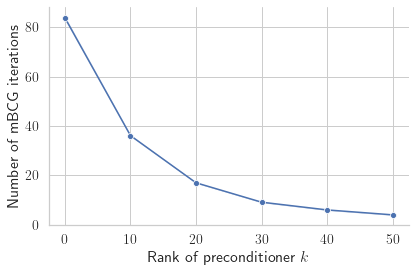

In [19]:
sns.lineplot(x='k', y='niter', data=df, marker='o')
plt.ylabel('Number of mBCG iterations')
plt.xlabel('Rank of preconditioner $k$')
process_figure('likelihood_mbcg_steps')

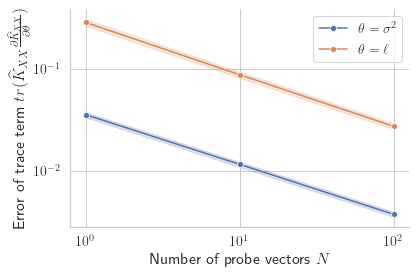

In [20]:
sns.lineplot(x='N', y='err_trace1', data=df, palette='deep', marker='o', label=r'$\theta = \sigma^2$')
sns.lineplot(x='N', y='err_trace2', data=df, palette='deep', marker='o', label=r'$\theta = \ell$')
plt.ylabel(r'Error of trace term $tr(\widehat K_{XX} \frac{\partial \widehat K_{XX}}{\partial \theta} )$')
plt.yscale('log');plt.xscale('log')
plt.xlabel('Number of probe vectors $N$');
process_figure('likelihood_traces')

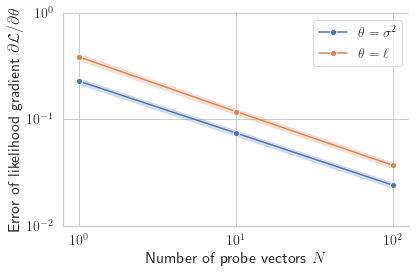

In [21]:
sns.lineplot(x='N', y='err_dL1', data=df, palette='deep', marker='o', label=r'$\theta = \sigma^2$')
sns.lineplot(x='N', y='err_dL2', data=df, palette='deep', marker='o', label=r'$\theta = \ell$')
plt.ylabel(r'Error of likelihood gradient $\partial \mathcal L / \partial \theta$')
plt.yscale('log');plt.xscale('log')
plt.xlabel('Number of probe vectors $N$');
plt.ylim(1e-2, 1e0);
process_figure('likelihood_gradient')

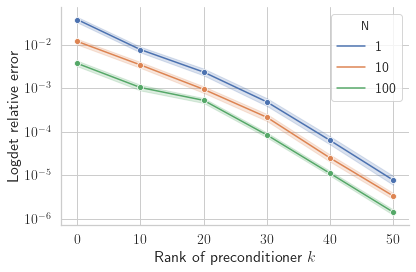

In [22]:
sns.lineplot(x='k', y='err_logdet', data=df, hue='N', palette='deep', marker='o')
plt.ylabel('Logdet relative error')
plt.xlabel('Rank of preconditioner $k$')
plt.yscale('log');
process_figure('likelihood_logdet')

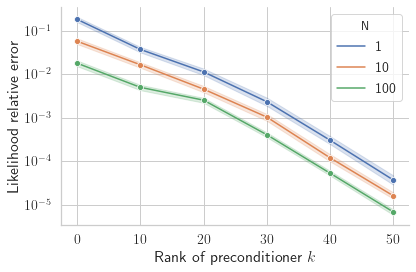

In [23]:
sns.lineplot(x='k', y='err_L', data=df, hue='N', palette='deep', marker='o')
plt.ylabel('Likelihood relative error')
plt.xlabel('Rank of preconditioner $k$')
plt.yscale('log');
process_figure('likelihood_likelihood')

# Regression example

In [6]:
from src.model import GPModel

In [95]:
%%time
n, d = 50, 1
sigma2 = 0.1
x = torch.rand(n, d)
f = lambda x: (2*torch.pi*x).sin()
y = f(x) + torch.randn(n, 1) * sigma2**0.5

lengthscale = 0.5
hyperparams = torch.tensor([0.01, lengthscale])

kernel = SquaredExponentialKernel(x)
model = GPModel(x, y, kernel, hyperparams)
pred_mean, pred_cov, l = model.train()

likelihood -233.68         MSE 1.1814          params [0.01, 0.5]
likelihood -163.56         MSE 0.6587          params [100.0, 0.01]
likelihood -134.56         MSE 0.68906         params [33.31880176675337, 0.3367705483977482]
likelihood -108.33         MSE 0.76045         params [11.120812295115522, 0.44555157491142505]
likelihood -108.26         MSE 0.76086         params [11.088115305300057, 0.4447538577082913]
likelihood -107.98         MSE 0.76255         params [10.957327346038198, 0.44156298889575624]
likelihood -106.83         MSE 0.7696          params [10.434175508990762, 0.428799513645616]
likelihood -101.6          MSE 0.80345         params [8.341568160801017, 0.3777456126450552]
likelihood -2.2115e+06     MSE 1.221           params [1e-06, 0.17423416823314858]
likelihood -92.226         MSE 0.86692         params [5.561096431981161, 0.3099097004273008]
likelihood -67.813         MSE 1.01            params [1.854034089020745, 0.21946750924215966]
likelihood -45.743       

In [96]:
kernel.sigma2, kernel.lengthscale

(0.12347726678332534, 0.15574952960994878)

In [97]:
grid = torch.linspace(0, 1, 100)
mu, cov = model.compute_prediction(grid)
std = cov**0.5

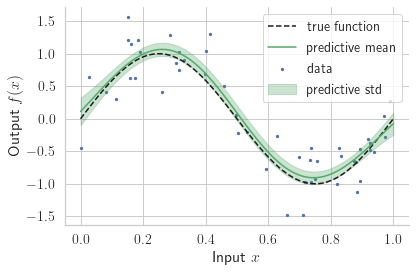

In [99]:
plt.scatter(x, y, s=5, label='data')
plt.plot(grid, f(grid), '--k', label='true function')
plt.plot(grid, mu, label='predictive mean', color='g')
plt.fill_between(grid, mu - std, mu + std, label='predictive std', color='g', alpha=.3)
plt.legend()
plt.xlabel('Input $x$'); plt.ylabel('Output $f(x)$')
process_figure('toy_example')

Repeat but have no data between $[0.2, 0.5]$ to show how the confidence interval increases:

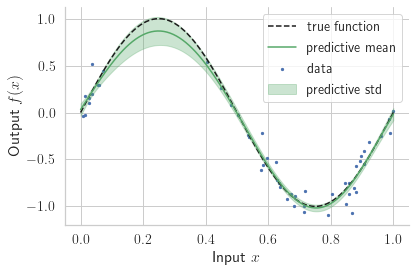

In [102]:
sigma2 = 0.01
x = torch.concat([
    torch.rand(10) * 0.1,
    torch.rand(40) * 0.6 + 0.4
]).reshape(-1, 1)
n = x.shape[0]

f = lambda x: (2*torch.pi*x).sin()
y = f(x) + torch.randn(n, 1) * sigma2**0.5

lengthscale = 0.5
hyperparams = torch.tensor([0.01, lengthscale])

kernel = SquaredExponentialKernel(x)
model = GPModel(x, y, kernel, hyperparams)
pred_mean, pred_cov, l = model.train(verbose=False)

grid = torch.linspace(0, 1, 200)
mu, cov = model.compute_prediction(grid)
std = cov**0.5

plt.scatter(x, y, s=5, label='data')
plt.plot(grid, f(grid), '--k', label='true function')
plt.plot(grid, mu, label='predictive mean', color='g')
plt.fill_between(grid, mu - std, mu + std, label='predictive std', color='g', alpha=.3)
plt.legend()
plt.xlabel('Input $x$'); plt.ylabel('Output $f(x)$')
process_figure('toy_example_widestd')